In [33]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 29 16:52:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              30W /  70W |   4159MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install transformers

In [37]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re


In [38]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/X11967"
tsvData = os.path.join(dataDir,"WoSDataset_11967.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(11967, 4)


In [39]:
print(tsvData[0:10])

[['2' 'Psychology'
  ' interview anxiety interview performance person perception job interview        '
  'the aim of this study was to investigate a the behavioral cues that are displayed by and trait judgments formed about anxious interviewees and b why anxious interviewees receive lower interview performance ratings the behavioral expression of interview anxiety model was created as a conceptual framework to explore these relations we videotaped and transcribed mock job interviews obtained ratings of interview anxiety and interview performance and trained raters to assess several verbal and nonverbal cues and trait judgments the results indicated that few behavioral cues but several traits were related to interviewee and interviewer ratings of interview anxiety two factors emerged from our factor analysis on the trait judgmentsassertiveness and interpersonal warmth mediation analyses were performed and indicated that assertiveness and interpersonal warmth mediated the relation betwe

In [40]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [41]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1499 2107 1132 1925 1617 1959 1728]


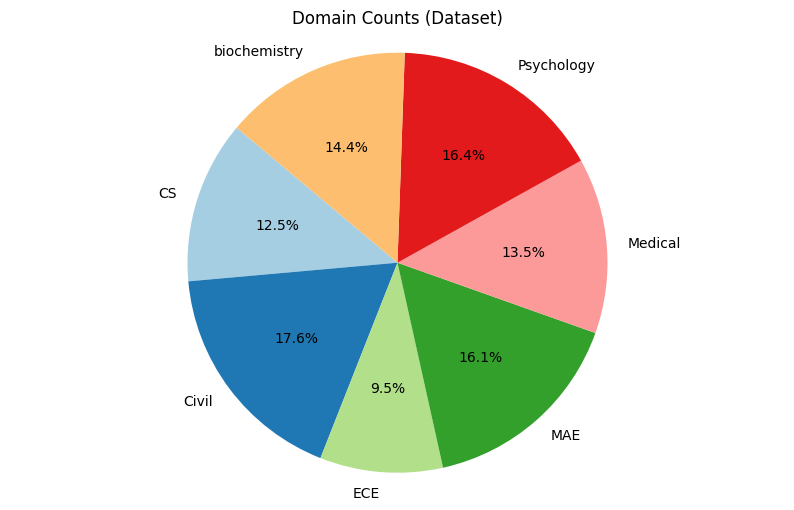

The domain CS has 1499 records in the dataset.
The domain Civil has 2107 records in the dataset.
The domain ECE has 1132 records in the dataset.
The domain MAE has 1925 records in the dataset.
The domain Medical has 1617 records in the dataset.
The domain Psychology has 1959 records in the dataset.
The domain biochemistry has 1728 records in the dataset.


In [42]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [43]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  11967
Shape of abstracts:  (11967,)
['inflammatory bowel disease ibd which includes both crohns disease cd and ulcerative colitis uc is a chronic idiopathic inflammatory disorder affecting the gastrointestinal tract extraintestinal manifestations eims are common in patients with ibd and occur in 647 of patients with cd or uc eims can involve organs other than the gastrointestinal tract such as skin eyes joints biliary tract and kidneys renal and urinary involvement particularly occurs in 423 of patients with ibd among the renal complications of ibd secondary amyloidosis aatype aaa is a rare but serious complication renal amyloidosis has been proven to be the most common lethal manifestation of ibdassociated amyloidosis since renal involvement rapidly leads to endstage renal failure a few studies suggest that aaa is more prevalent in cd than in uc mainly occurring in male patients with an extensive longlasting and penetrating disease pattern the therapeutic approac

In [44]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

(9573, 4)
(2394, 4)
(9573, 4)
(2394, 4)
(479, 4)


In [45]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  9573
Shape of abstracts:  (9573,)
Number of keywords:  9573
Shape of keywords:  (9573,)
Number of domains:  9573
Shape of domains:  (9573,)
Number of labels:  9573
Shape of labels:  (9573,)
['the study examined the social skills of 92 russian children males  64 adopted by italian families the children aged between 8 and 14 years were compared with a control group of children who grew up with the biological family evaluation by both parents and children of the childrens social competence were investigated the results showed that according to the parents reports the adopted children had more problems in social functioning than peers in the control group along with a greater propensity to use maladaptive behaviors such as oppositive behavior rulebreaking behavior aggressive behavior and externalization by contrast according to the childrens assessments the adopted children were less aggressive and used prosocial behaviors to a greater extent than children raised in t

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1218 1649  923 1501 1319 1575 1388]


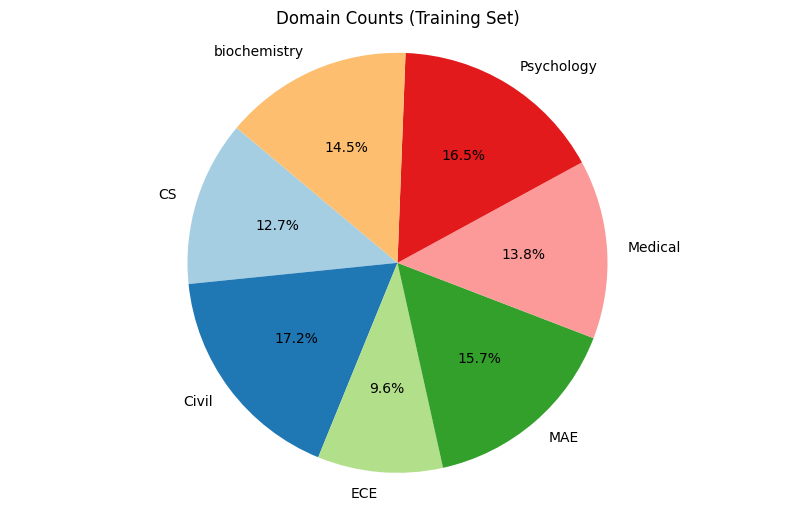

The domain CS has 1218 records in the training set.
The domain Civil has 1649 records in the training set.
The domain ECE has 923 records in the training set.
The domain MAE has 1501 records in the training set.
The domain Medical has 1319 records in the training set.
The domain Psychology has 1575 records in the training set.
The domain biochemistry has 1388 records in the training set.


In [46]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [47]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  2394
Shape of abstracts:  (2394,)
Number of keywords:  2394
Shape of keywords:  (2394,)
Number of domains:  2394
Shape of domains:  (2394,)
Number of labels:  2394
Shape of labels:  (2394,)
['piezoelectric fans have been studied extensively and are seen as a promising technology for thermal management due to their ability to provide quiet reliable cooling with low power consumption the fluid mechanics associated with a piezoelectric fan are similar to that for a flapping bird wing which are known to be complex this paper is the first to investigate the threedimensional fluid mechanics of an unconfined fan operating in its first vibration frequency mode a custom built experimental facility was developed to capture the fans flow field using twodimensional phase locked particle image velocimetry piv the fluidstructure interaction was also captured through unique twoway coupled threedimensional simulations of an oscillating beam in which the beam is actuated by a shea

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [281 458 209 424 298 384 340]


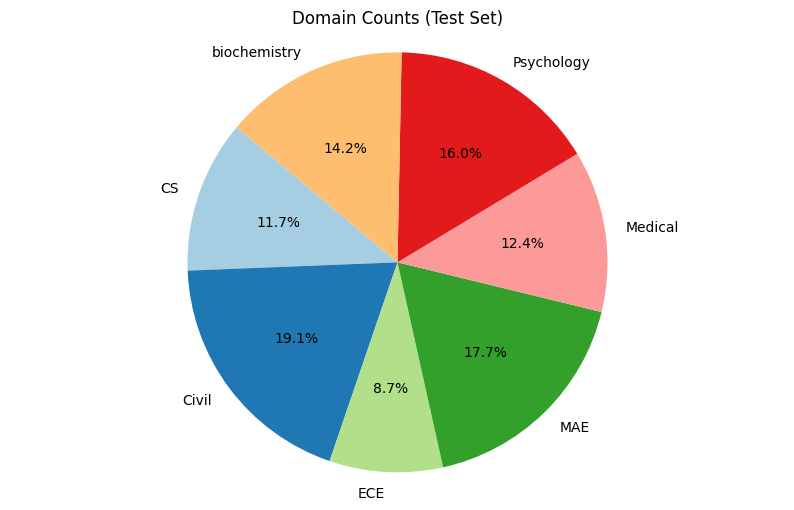

The domain CS has 281 records in the test set.
The domain Civil has 458 records in the test set.
The domain ECE has 209 records in the test set.
The domain MAE has 424 records in the test set.
The domain Medical has 298 records in the test set.
The domain Psychology has 384 records in the test set.
The domain biochemistry has 340 records in the test set.


In [48]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [49]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  479
Shape of abstracts:  (479,)
Number of keywords:  479
Shape of keywords:  (479,)
Number of domains:  479
Shape of domains:  (479,)
Number of labels:  479
Shape of labels:  (479,)
['with the great success of the secondgeneration wireless telephone technology and the thirdgeneration mobile telecommunications technology and the fast development of the fourthgeneration mobile telecommunications technology the phase of fifthgeneration mobile networks or fifthgeneration wireless systems 5g is coming in this article we indicate the open research issues of 5g security and trust in the context of virtualized networking and softwaredefined networking we further propose a framework of security and trust focusing on solving 5g network security issues the proposed framework applies adaptive trust evaluation and management technologies and sustainable trusted computing technologies to ensure computing platform trust and achieve softwaredefined network security it adopts clou

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [64 84 32 80 68 81 70]


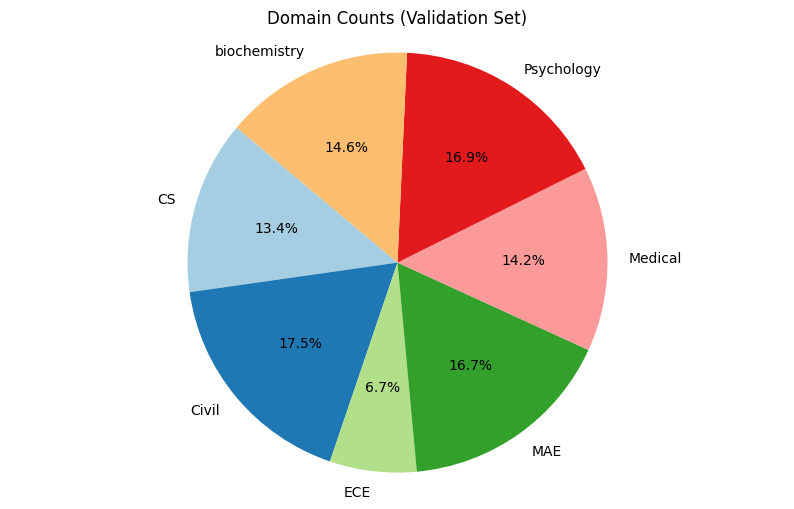

The domain CS has 64 records in the vaidation set.
The domain Civil has 84 records in the vaidation set.
The domain ECE has 32 records in the vaidation set.
The domain MAE has 80 records in the vaidation set.
The domain Medical has 68 records in the vaidation set.
The domain Psychology has 81 records in the vaidation set.
The domain biochemistry has 70 records in the vaidation set.


In [50]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [51]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstracts
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [52]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(9573, 4)
(2394, 4)
(479, 4)


In [53]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  9573
Label length  479
Label length  2394


In [54]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [55]:
model.config

BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

In [56]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [57]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [58]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 300/300 [03:11<00:00,  1.57batch/s]


Epoch 1/20
  Train Loss: 0.5989201717823743
  Val Micro F1: 0.8684759916492694
  Time: 3m 14s


Epoch 2/20: 100%|██████████| 300/300 [03:10<00:00,  1.57batch/s]


Epoch 2/20
  Train Loss: 0.23394950684780877
  Val Micro F1: 0.8956158663883089
  Time: 3m 14s


Epoch 3/20: 100%|██████████| 300/300 [03:10<00:00,  1.57batch/s]


Epoch 3/20
  Train Loss: 0.1416627359436825
  Val Micro F1: 0.8977035490605428
  Time: 3m 14s


Epoch 4/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 4/20
  Train Loss: 0.08010256132499004
  Val Micro F1: 0.8851774530271399
  Time: 3m 13s


Epoch 5/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 5/20
  Train Loss: 0.05140880016804052
  Val Micro F1: 0.906054279749478
  Time: 3m 13s


Epoch 6/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 6/20
  Train Loss: 0.022838485107252685
  Val Micro F1: 0.8893528183716075
  Time: 3m 13s


Epoch 7/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 7/20
  Train Loss: 0.012290955249336549
  Val Micro F1: 0.8956158663883089
  Time: 3m 13s


Epoch 8/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 8/20
  Train Loss: 0.007653954147632855
  Val Micro F1: 0.9102296450939458
  Time: 3m 13s


Epoch 9/20: 100%|██████████| 300/300 [03:10<00:00,  1.57batch/s]


Epoch 9/20
  Train Loss: 0.004337858236394823
  Val Micro F1: 0.9018789144050104
  Time: 3m 14s


Epoch 10/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 10/20
  Train Loss: 0.003920638060226338
  Val Micro F1: 0.8977035490605428
  Time: 3m 13s


Epoch 11/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 11/20
  Train Loss: 0.0012731530544018218
  Val Micro F1: 0.8997912317327766
  Time: 3m 13s


Epoch 12/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 12/20
  Train Loss: 0.00242266972491052
  Val Micro F1: 0.8956158663883089
  Time: 3m 13s


Epoch 13/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 13/20
  Train Loss: 0.001123333067225758
  Val Micro F1: 0.8997912317327766
  Time: 3m 13s


Epoch 14/20: 100%|██████████| 300/300 [03:10<00:00,  1.57batch/s]


Epoch 14/20
  Train Loss: 0.0006689360948803368
  Val Micro F1: 0.8997912317327766
  Time: 3m 14s


Epoch 15/20: 100%|██████████| 300/300 [03:10<00:00,  1.57batch/s]


Epoch 15/20
  Train Loss: 0.00022905362449819223
  Val Micro F1: 0.9039665970772442
  Time: 3m 14s


Epoch 16/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 16/20
  Train Loss: 0.00040892652151039026
  Val Micro F1: 0.8977035490605428
  Time: 3m 13s


Epoch 17/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 17/20
  Train Loss: 0.00012704396785314506
  Val Micro F1: 0.9018789144050104
  Time: 3m 13s


Epoch 18/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 18/20
  Train Loss: 0.00011818201366016487
  Val Micro F1: 0.9018789144050104
  Time: 3m 13s


Epoch 19/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 19/20
  Train Loss: 0.0004968292575358646
  Val Micro F1: 0.9018789144050104
  Time: 3m 14s


Epoch 20/20: 100%|██████████| 300/300 [03:10<00:00,  1.58batch/s]


Epoch 20/20
  Train Loss: 0.0001243506183527643
  Val Micro F1: 0.9039665970772442
  Time: 3m 13s


In [59]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[254   2   3   5  10   2   5]
 [  0 199   0   6   4   0   0]
 [  2   0 363   0   2  16   1]
 [  9  13   2 379  10   1  10]
 [  9   2   2  11 432   1   1]
 [  0   0  14   1   1 268  14]
 [  2   1   4   0   2  19 312]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       281
           1       0.92      0.95      0.93       209
           2       0.94      0.95      0.94       384
           3       0.94      0.89      0.92       424
           4       0.94      0.94      0.94       458
           5       0.87      0.90      0.89       298
           6       0.91      0.92      0.91       340

    accuracy                           0.92      2394
   macro avg       0.92      0.92      0.92      2394
weighted avg       0.92      0.92      0.92      2394

Macro F1 Score: 0.9205871756165026
Micro F1 Score: 0.9218880534670009
Weighted F1 Score: 0.9218835232341194
Macro Precision: 0.91933886605722

In [60]:
model.save_pretrained('/content/drive/MyDrive/WoS/SciBERT_WoS_Abstracts_11967')